In [1]:
import numpy as np
import mne
import matplotlib.pyplot as plt


In [2]:
file_path = '/Users/e4/E-2/DEAP_DATA/s01.dat'
data = np.fromfile(file_path, dtype=np.float32)

n_channels = 40       
n_time_points = 8064  
n_trials = len(data) // (n_channels * n_time_points)
data = data[:n_trials * n_channels * n_time_points].reshape(n_trials, n_channels, n_time_points)
subset = data[:10]  
print(subset.shape)

(10, 40, 8064)


In [3]:
if np.isnan(subset).any() or np.isinf(subset).any(): 
    subset = np.nan_to_num(subset)
    print("NaNs or Infs found and replaced.")
else:
    print("No NaNs or Infs found.")

NaNs or Infs found and replaced.


In [4]:
subset_flattened = subset.reshape(n_channels, 10 * n_time_points)
info = mne.create_iafo(ch_names=[f'EEG {i+1}' for i in range(n_channels)], sfreq=128, ch_types='eeg')
raw = mne.io.RawArray(subset_flattened, info)
print(raw.info)

Creating RawArray with float64 data, n_channels=40, n_times=80640
    Range : 0 ... 80639 =      0.000 ...   629.992 secs
Ready.
<Info | 7 non-empty values
 bads: []
 ch_names: EEG 1, EEG 2, EEG 3, EEG 4, EEG 5, EEG 6, EEG 7, EEG 8, EEG 9, ...
 chs: 40 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 40
 projs: []
 sfreq: 128.0 Hz
>


In [5]:
standard_1020_names = [
    'Fp1', 'Fp2', 'F7', 'F8', 'F3', 'F4', 'Fz', 'T7', 'Cz', 'T8', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'O2',
    'AF7', 'AF3', 'AF4', 'AF8', 'FC5', 'FC1', 'FC2', 'FC6', 'CP5', 'CP1', 'CP2', 'CP6', 'PO7', 'PO3', 'POz', 
    'PO4', 'PO8', 'FT7', 'FT8', 'TP7', 'TP8', 'Oz', 'Fpz'
]

In [6]:
mapping = {f'EEG {i+1}': standard_1020_names[i] for i in range(n_channels)}
raw.rename_channels(mapping)

<RawArray | 40 x 80640 (630.0 s), ~24.6 MB, data loaded>

In [7]:
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)

<RawArray | 40 x 80640 (630.0 s), ~24.7 MB, data loaded>

Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 1281 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 10 events and 1281 original time points ...
Using matplotlib as 2D backend.
Using data from preloaded Raw for 10 events and 1281 original time points ...


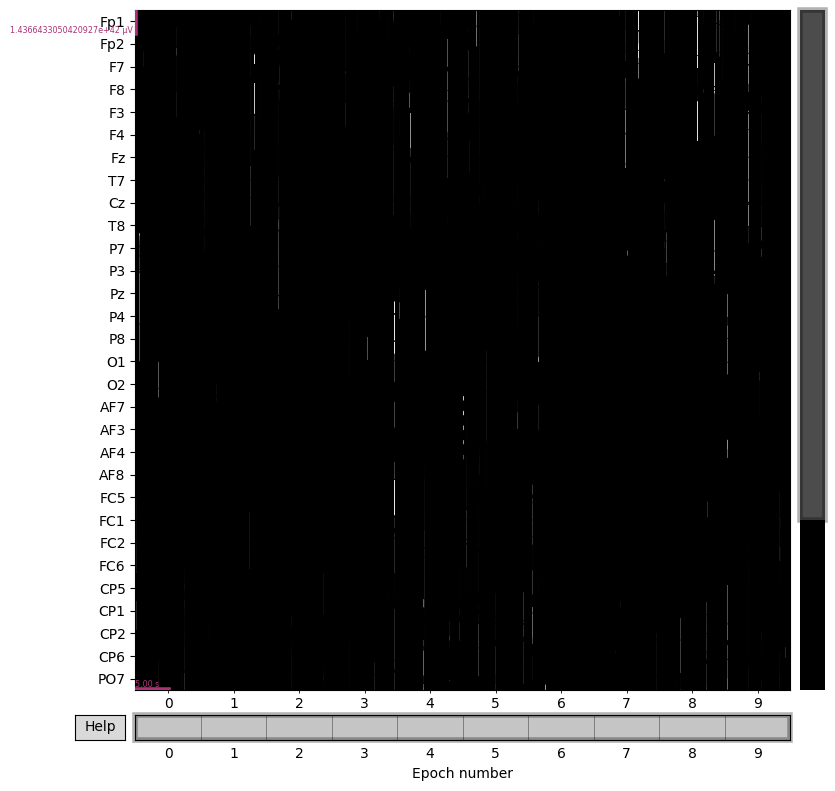

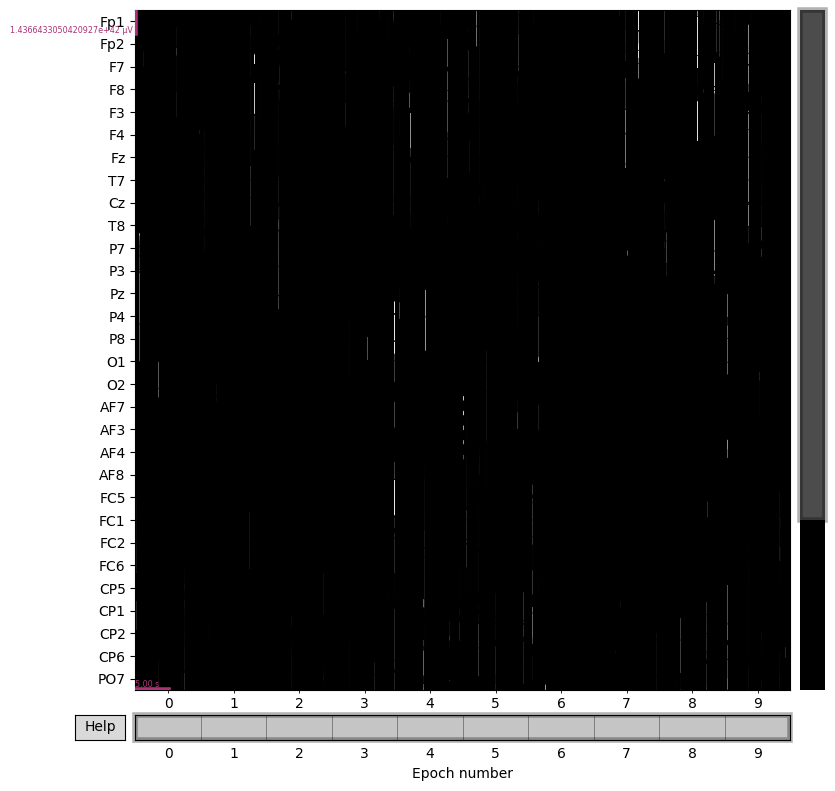

In [8]:
events = np.array([[i * n_time_points, 0, 1] for i in range(10)])
epochs = mne.Epochs(raw, events, event_id=1, tmin=0, tmax=10, baseline=None, detrend=1)
epochs.plot(n_channels=30, scalings='auto', title='Epochs')


Using data from preloaded Raw for 10 events and 1281 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


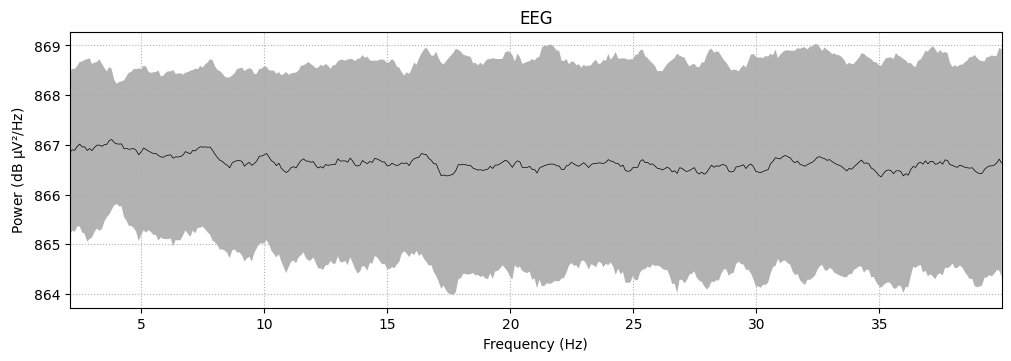

In [9]:
epochs.compute_psd(fmin=2.0, fmax=40.0).plot(
    average=True, amplitude=False, picks="data", exclude="bads"
)

In [10]:
_, ax = plt.subplots()
spectrum = epochs.compute_psd(fmin=2.0, fmax=40.0, tmax=3.0, n_jobs=None)

mean_spectrum = spectrum.average()
psds, freqs = mean_spectrum.get_data(return_freqs=True)

psds = 10 * np.log10(psds)
psds_mean = psds.mean(axis=0)
psds_std = psds.std(axis=0)

ax.plot(freqs, psds_mean, color="k")
ax.fill_between(
    freqs,
    psds_mean - psds_std,
    psds_mean + psds_std,
    color="k",
    alpha=0.5,
    edgecolor="none",
)
ax.set(
    title="Multitaper PSD (gradiometers)",
    xlabel="Frequency (Hz)",
    ylabel="Power Spectral Density (dB)",
)

Using data from preloaded Raw for 10 events and 1281 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows


[Text(0.5, 1.0, 'Multitaper PSD (gradiometers)'),
 Text(0.5, 0, 'Frequency (Hz)'),
 Text(0, 0.5, 'Power Spectral Density (dB)')]

In [11]:
# Estimate PSDs based on "mean" and "median" averaging for comparison.
kwargs = dict(fmin=2, fmax=40, n_jobs=None)
psds_welch_mean, freqs_mean = epochs.compute_psd(
    "welch", average="mean", **kwargs
).get_data(return_freqs=True)
psds_welch_median, freqs_median = epochs.compute_psd(
    "welch", average="median", **kwargs
).get_data(return_freqs=True)

# Convert power to dB scale.
psds_welch_mean = 10 * np.log10(psds_welch_mean)
psds_welch_median = 10 * np.log10(psds_welch_median)

# We will only plot the PSD for a single sensor in the first epoch.
ch_name = "Fp1"
ch_idx = epochs.info["ch_names"].index(ch_name)
epo_idx = 0

_, ax = plt.subplots()
ax.plot(
    freqs_mean,
    psds_welch_mean[epo_idx, ch_idx, :],
    color="k",
    ls="-",
    label="mean of segments",
)
ax.plot(
    freqs_median,
    psds_welch_median[epo_idx, ch_idx, :],
    color="k",
    ls="--",
    label="median of segments",
)

ax.set(
    title=f"Welch PSD ({ch_name}, Epoch {epo_idx})",
    xlabel="Frequency (Hz)",
    ylabel="Power Spectral Density (dB)",
)
ax.legend(loc="upper right")

Using data from preloaded Raw for 10 events and 1281 original time points ...
Effective window size : 10.008 (s)
Using data from preloaded Raw for 10 events and 1281 original time points ...
Effective window size : 10.008 (s)


In [12]:
freqs = np.logspace(*np.log10([6, 35]), num=8)
n_cycles = freqs / 2.0  # different number of cycle per frequency
power, itc = epochs.compute_tfr(
    method="morlet",
    freqs=freqs,
    n_cycles=n_cycles,
    average=True,
    return_itc=True,
    decim=3,
)

Using data from preloaded Raw for 10 events and 1281 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)


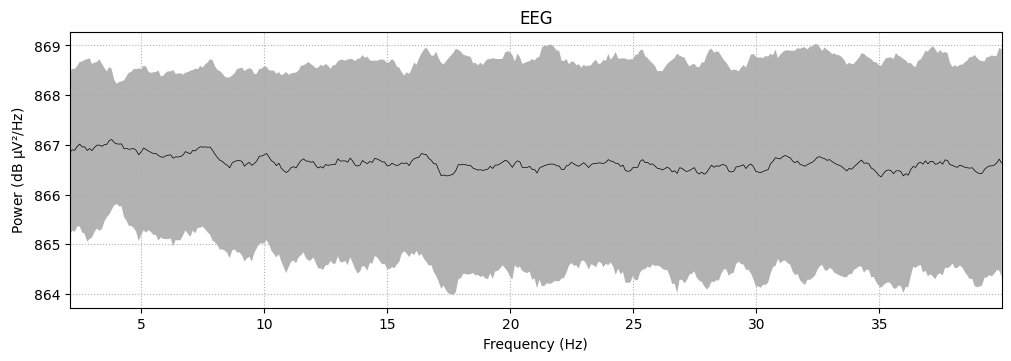

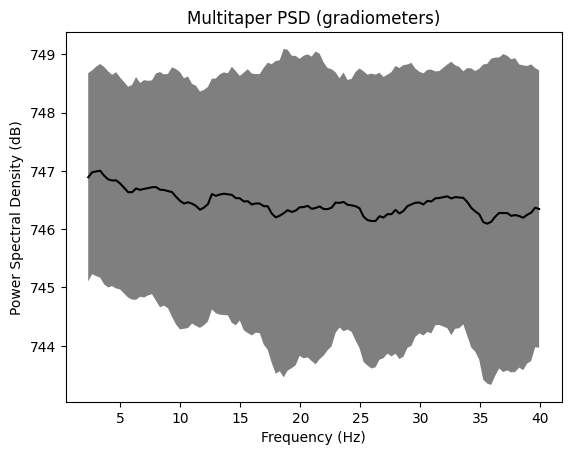

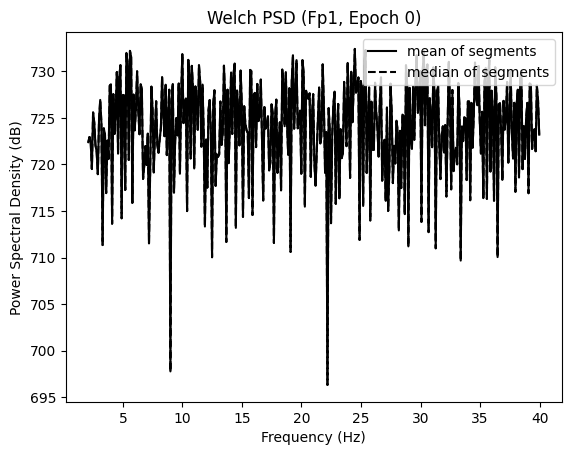

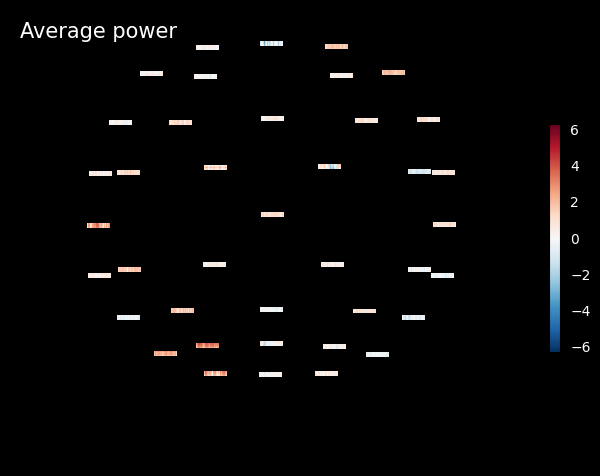

Applying baseline correction (mode: logratio)


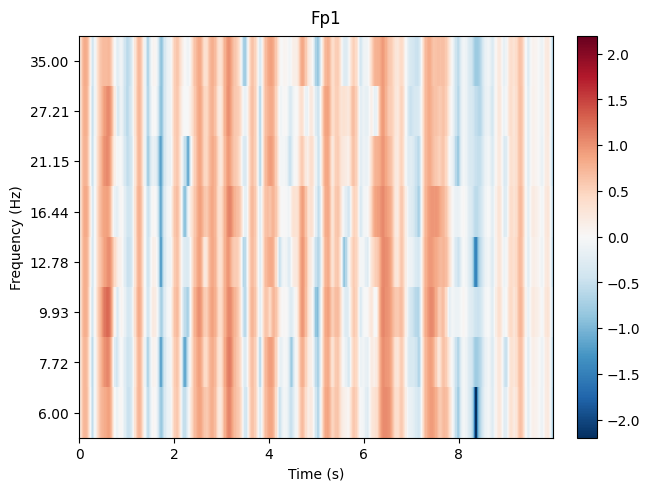

Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)


In [13]:
power.plot_topo(baseline=(-0.5, 0), mode="logratio", title="Average power")

valid_channel_index = 0  
if valid_channel_index < len(power.ch_names):
    power.plot(picks=[valid_channel_index], baseline=(-0.5, 0), mode="logratio", title=power.ch_names[valid_channel_index])
else:
    print(f"Invalid channel index: {valid_channel_index}. Available channels: {len(power.ch_names)}")

fig, axes = plt.subplots(1, 2, figsize=(7, 4), layout="constrained")
topomap_kw = dict(
    ch_type="eeg", tmin=0.5, tmax=1.5, baseline=(-0.5, 0), mode="logratio", show=False
)
plot_dict = dict(Alpha=dict(fmin=8, fmax=12), Beta=dict(fmin=13, fmax=25))
for ax, (title, fmin_fmax) in zip(axes, plot_dict.items()):
    power.plot_topomap(**fmin_fmax, axes=ax, **topomap_kw)
    ax.set_title(title)


Using data from preloaded Raw for 10 events and 1281 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs before plotting...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mne/viz/topomap.py:2866: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.draw()


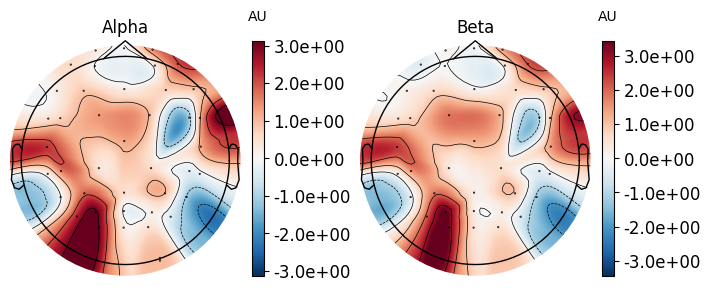

/Users/e4/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


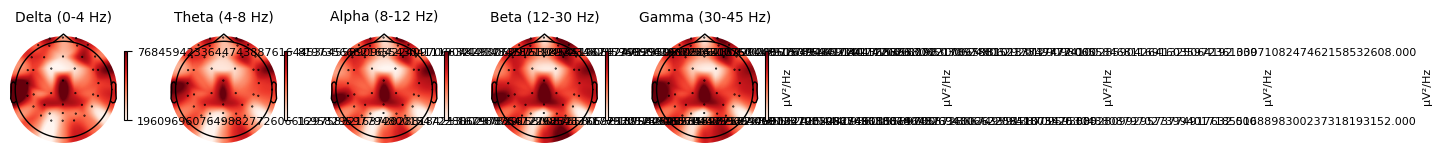

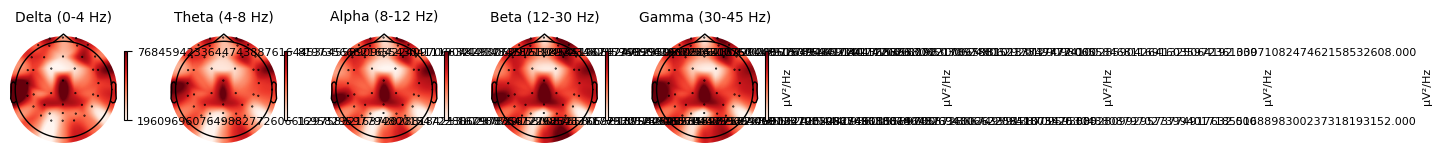

In [14]:
epochs.compute_psd().plot_topomap(ch_type="eeg", normalize=False, contours=0)